In [14]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [15]:
# Define the ticker symbol
tickerSymbol = 'USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2021-01-01 00:00:00-05:00,26.030947,28.283889,25.196063,28.144327,1321600,0.0,0.0,0.0
2021-01-08 00:00:00-05:00,29.343072,30.678887,27.568632,30.130606,1107600,0.0,0.0,0.0
2021-01-15 00:00:00-05:00,30.247740,31.912524,28.565510,31.633398,1223200,0.0,0.0,0.0
2021-01-22 00:00:00-05:00,31.107545,31.267045,26.277677,27.601030,1207200,0.0,0.0,0.0
2021-01-29 00:00:00-05:00,27.748069,30.068301,26.666458,29.041517,758800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-08-09 00:00:00-04:00,96.110001,124.669998,93.879997,123.750000,3512500,0.0,0.0,0.0
2024-08-16 00:00:00-04:00,121.959999,135.570007,120.550003,122.370003,3037900,0.0,0.0,0.0
2024-08-23 00:00:00-04:00,126.419998,132.869995,112.510002,113.629997,2954500,0.0,0.0,0.0


In [16]:
max_weeks = 52

In [17]:

gap = (1/100)*100

option_prices = {
    1: [94/1.95],
    2: [90/4.05, 92/7.30],
    3: [91/5.15],
    4: [81/5.4, 74/5.1, 131/12.1],
    5: [100/7.05, 126/12.05],
    6: [94/7.4, 92/11.30],
    7: [90/8.25],
    8: [91/8.05, 131/16.05],
    9: [81/8.45, 100/9.4, 126/15.6],
    10: [93/13.95],
    12: [131/19.6],
    13: [100/11.5, 126/19.2],
    14: [94/10.55],
    15: [90/11.15],
    16: [91/12.75],
    17: [81/11.3, 74/10.4],
    24: [93/19.50],
    26: [100/18.55, 131/27.85],
    27: [94/17.25, 126/26.35],
    28: [90/16.9],
    29: [91/17.55],
    30: [81/14.95]
}

polygon_data = {
    1: 39.78571428571429,
    2: 26.896551724137932,
    3: 19.767441860465116,
    4: 18.01948051948052,
    5: 15.074595055413472,
    6: 13.310023310023311,
    7: 11.9, #13.772609819121445,
    8: 10.511111111111111,
}
for k, v in polygon_data.items():
    if not k in option_prices:
        option_prices[k] = []
    option_prices[k].append(v)

print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 1w 48.2 39.8
	 2w 22.2 12.6 26.9
	 3w 17.7 19.8
	 4w 15.0 14.5 10.8 18.0
	 5w 14.2 10.5 15.1
	 6w 12.7  8.1 13.3
	 7w 10.9 11.9
	 8w 11.3  8.2 10.5
	 9w  9.6 10.6  8.1
	10w  6.7
	12w  6.7
	13w  8.7  6.6
	14w  8.9
	15w  8.1
	16w  7.1
	17w  7.2  7.1
	24w  4.8
	26w  5.4  4.7
	27w  5.4  4.8
	28w  5.3
	29w  5.2
	30w  5.4
mean option leverage, break even:
	 1w 44.0  3.3%
	 2w 20.6  5.9%
	 3w 18.7  6.3%
	 4w 14.6  7.9%
	 5w 13.2  8.6%
	 6w 11.4  9.8%
	 7w 11.4  9.8%
	 8w 10.0 11.0%
	 9w  9.4 11.6%
	10w  6.7 16.0%
	12w  6.7 16.0%
	13w  7.6 14.1%
	14w  8.9 12.2%
	15w  8.1 13.4%
	16w  7.1 15.0%
	17w  7.1 15.0%
	24w  4.8 22.0%
	26w  5.0 20.8%
	27w  5.1 20.5%
	28w  5.3 19.8%
	29w  5.2 20.3%
	30w  5.4 19.5%
option gap: 1.00%


In [18]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [19]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 1w   67%  40%   13%
	 2w   29%  41%  -31%
	 3w   57%  42%    1%
	 4w   46%  38%  -15%
	 5w   55%  40%   -8%
	 6w   53%  42%  -19%
	 7w   69%  44%   -1%
	 8w   63%  43%  -12%
	 9w   65%  46%   -4%
	10w   24%  42%  -50%
	12w   47%  44%  -19%
	13w   81%  49%   19%
	14w  126%  55%   78%
	15w  117%  54%   70%
	16w  105%  54%   52%
	17w  118%  52%   89%
	24w  110%  53%   57%
	26w  141%  57%   85%
	27w  155%  57%  109%
	28w  176%  58%  144%
	29w  180%  61%  151%
	30w  205%  61%  177%


In [20]:
from file import save_file

save_file(tickerSymbol, option_performance)

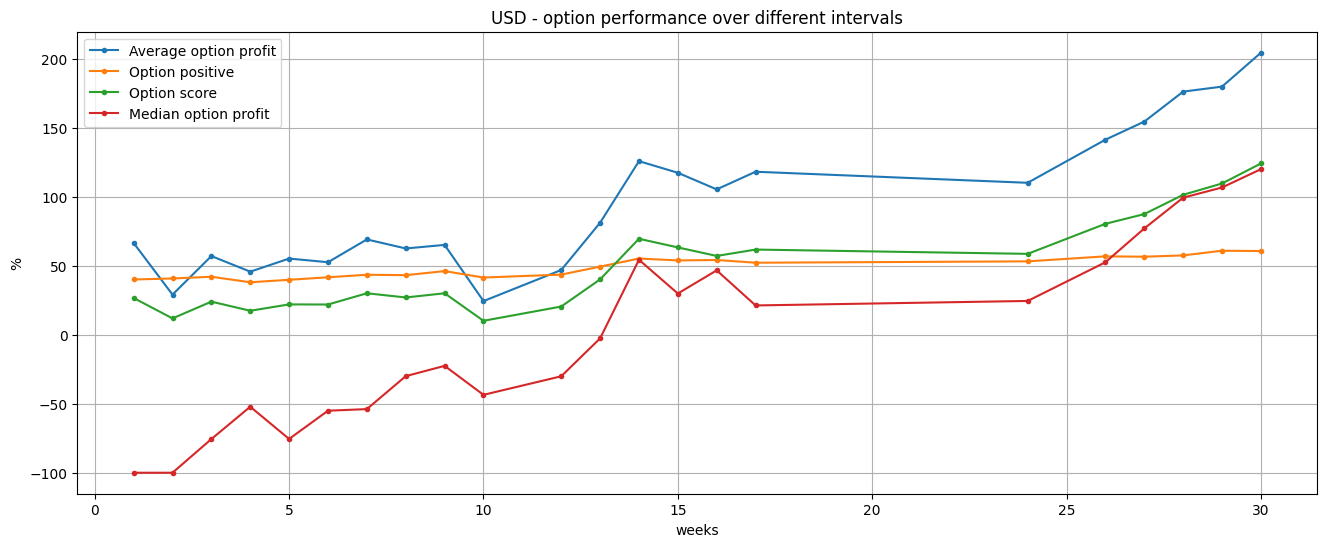

In [21]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_mprofit = [p[4] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.plot(option_weeks, option_mprofit, label='Median option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

In [22]:
weeks = 4
history['stock_change'] = history['Close'].pct_change(periods=weeks) * 100
history['whigh'] = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
lvr = option_leverage[weeks]
history['wmax_profit'] = (((history['whigh'] / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)


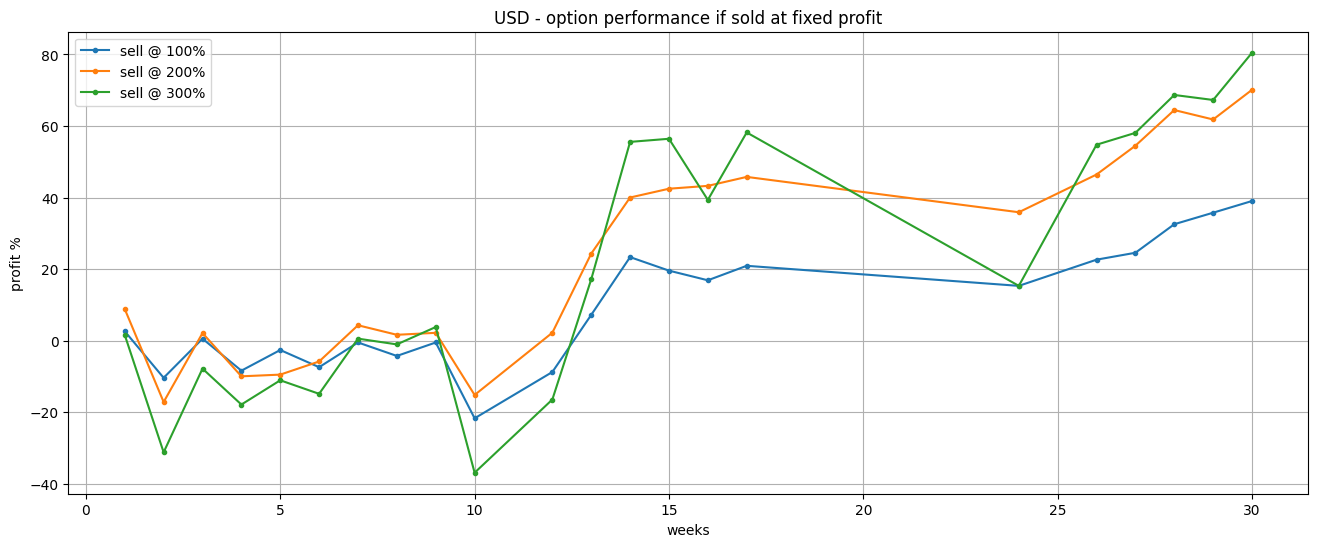

In [23]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

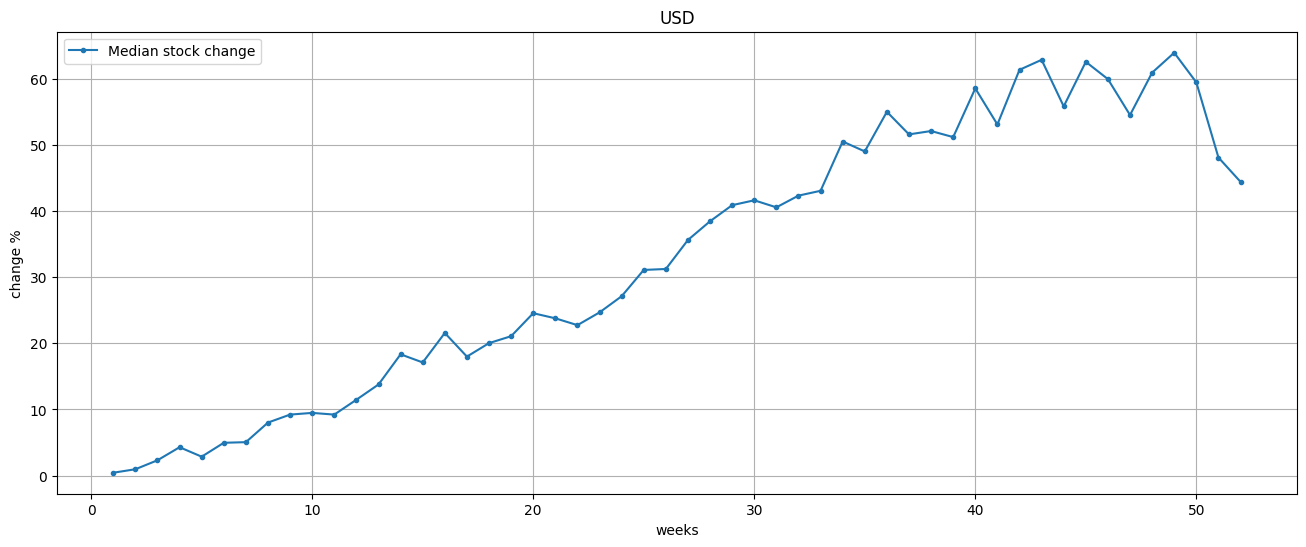

In [24]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


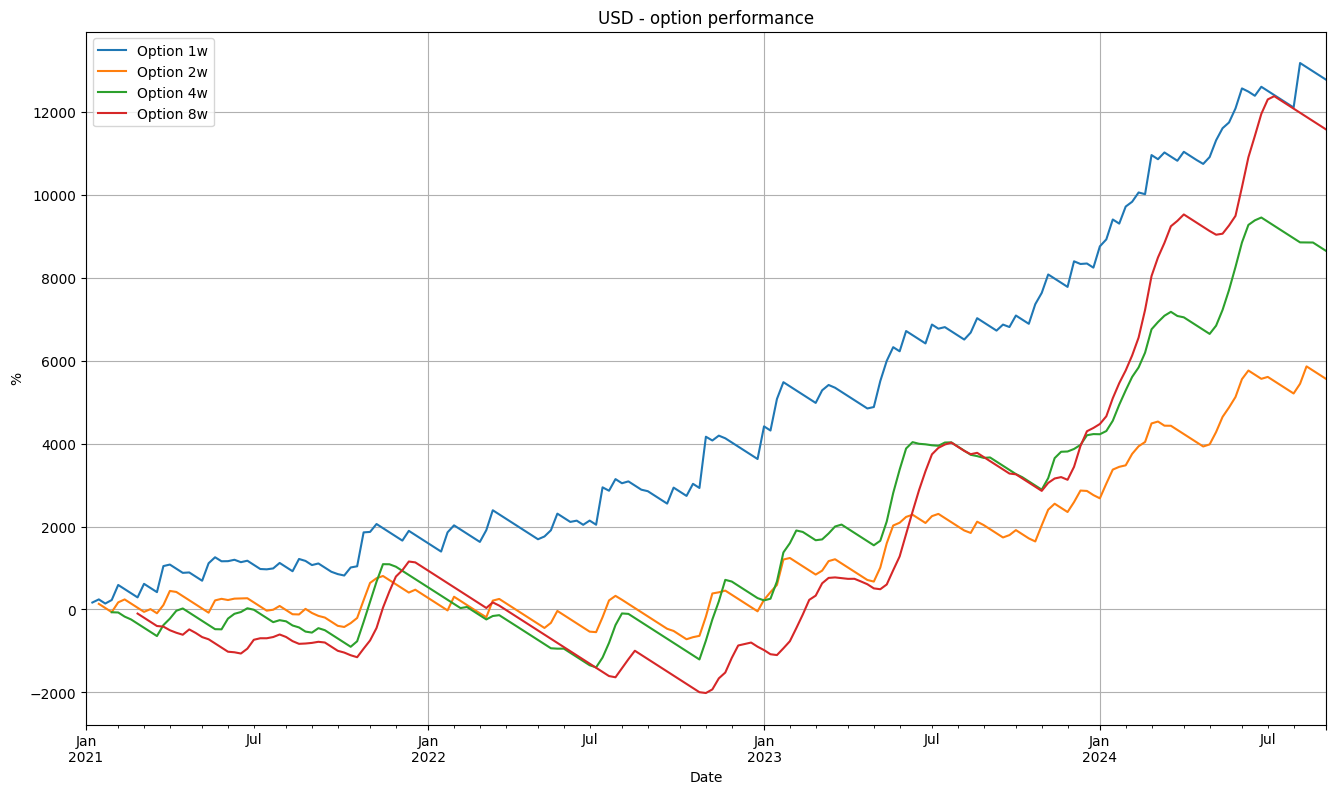

In [25]:
plt.figure(figsize=(16,9))

for w in [1,2,4,8]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


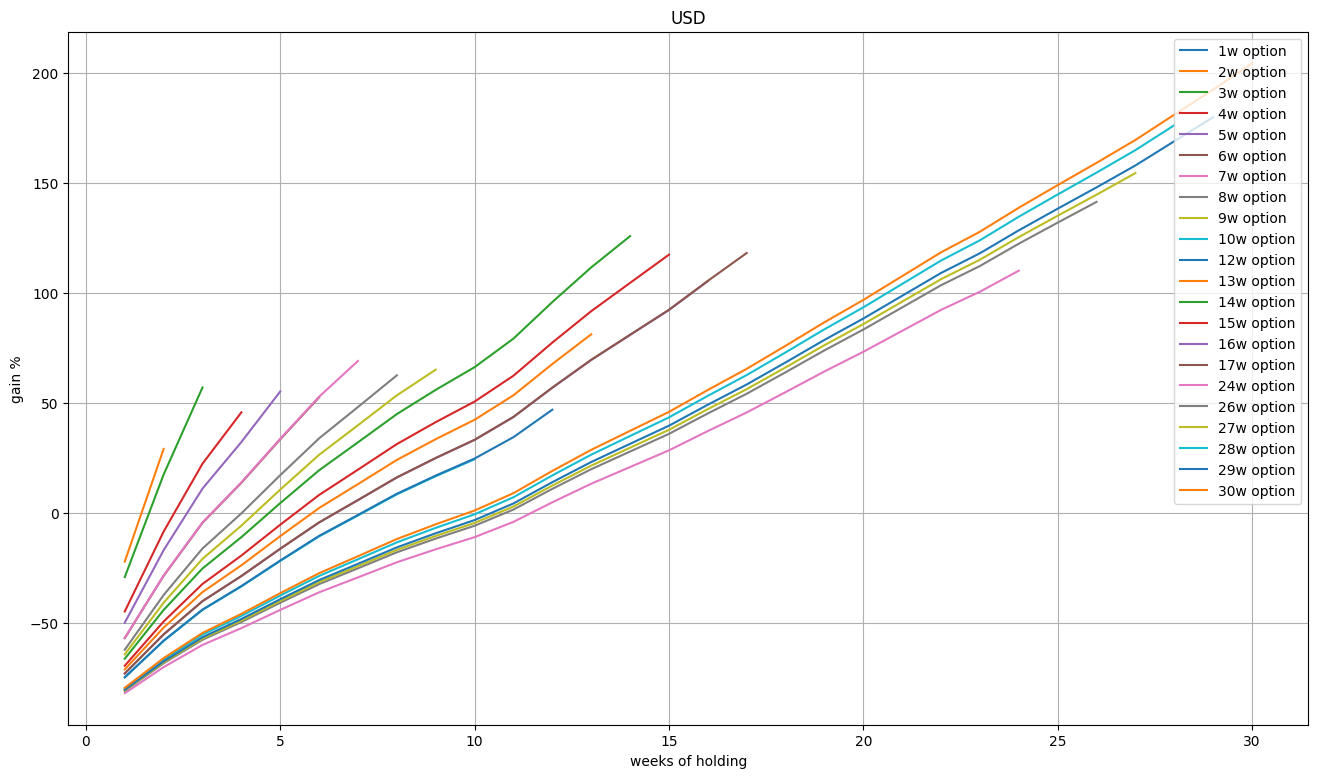

In [26]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = [None]
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain %')
plt.grid()
plt.show()